# Visualizing Tchaikovsky

## Scraping and cleaning data from IMSLP

In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup

url = "https://imslp.org/wiki/List_of_works_by_Pyotr_Tchaikovsky"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

Get the table

In [2]:
table = soup.find("table")
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Remove new line from each string in the process
    cell_contents = [cell.text.replace("\n", "") for cell in cells]
    table_text.append(cell_contents)
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])
raw_works.head()

,TH,Opus,Title (IMSLP),Title (Cyrillic),Forces,Key,Date,Genre,Notes
0,001,03,The Voyevoda,Воевода,vv ch orch,,1867–68,Stage,opera in 3 acts and 4 scene; destroyed by Tch...
1,001,—,Entr'acte and Dances of the Chambermaids,Антракт и пляска сенных девушек,pf,,1867,Keyboard,arr. from Act II No.4 of TH 1; based on TH 37
2,001,—,Entr'acte and Dances of the Chambermaids,Антракт и пляска сенных девушек,pf4h,,1868,Keyboard,arr. from Act II No.4 of TH 1; based on TH 37
3,002,—,Undina,Ундина,vv ch orch,,1869,Stage,opera in 3 acts; mostly destroyed by Tchaikov...
4,003,—,The Oprichnik,Опричник,vv ch orch,,"1870–72, rev.1874–78",Stage,opera in 4 acts and 5 scenes; vocal score arr...


In [3]:
raw_works.tail()

,TH,Opus,Title (IMSLP),Title (Cyrillic),Forces,Key,Date,Genre,Notes
506,252,—,Waltz,Вальс,vc pf/(orch?),,1893?,Chamber,unrealized sketch.
507,253,—,Fragments,Фрагменты,pf (?),,1893?,Keyboard,miscellaneous sketches found with TH 252
508,254,—,Piano Piece,Пьес для фортепияно,pf,A minor,1893?,Keyboard,fragment from an unidentified piece
509,255,—,Guide to the Practical Study of Harmony,Руководство к практическому изучению гармоний,,,1871,Writings,text book for students.
510,256,—,A Short Study Manual of Harmony,Краткий учебник гармоний,,,1875,Writings,"""Adapted for the study of church music in Rus..."


In [4]:
raw_works.shape

(511, 9)

## Clean the raw data

In [5]:
df = raw_works.copy()
df.columns = [column.lower() for column in df.columns]
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [6]:
# ONLY consider compositions with Opus number
df = df[df['opus'] != '—' ]
df.drop(columns = ['th'], inplace = True)
df.head()

,opus,title (imslp),title (cyrillic),forces,key,date,genre,notes
0,03,The Voyevoda,Воевода,vv ch orch,,1867–68,Stage,opera in 3 acts and 4 scene; destroyed by Tcha...
5,14,Vakula the Smith,Кузнец Вакула,vv ch orch,,1874,Stage,comic opera in 3 acts and 8 scenes; 1st versio...
6,24,Eugene Onegin (Yevgeny Onegin),Евгений Онегин,vv ch orch,,"1877–78, rev.1880, 1885",Stage,lyrical scenes in 3 acts and 7 tableaux; vocal...
11,68,The Queen of Spades,Пиковая дама,vv ch orch,,1890,Stage,opera in 3 acts and 7 scenes; vocal score arr....
12,69,Iolanta,Иоланта,vv ch orch,,1891,Stage,lyrical opera in 1 act.


The easiest way to get rid of these header-subheader type rows is to remove rows without keys.

In [7]:
df.rename(columns = {'title (imslp)':'title', 'title (cyrillic)': 'russian title', 'forces':'instruments'}, inplace = True) 

In [8]:
if len(df[df["date"] == ""]) !=0:
    df = df[df["date"] != ""]

In [9]:
if len(df[df["key"] == ""]) != 0:
    df = df[df["key"] != ""]

Check how many different keys did Beethoven use in his compositions.

In [10]:
df['key']= df['key'].replace('B♭ mino','B♭ minor')
sorted(df["key"].unique())

['A major',
 'A minor',
 'A minor–A major',
 'A♭ major',
 'A♭ minor',
 'B major',
 'B minor',
 'B♭ major',
 'B♭ major/E♭ major',
 'B♭ minor',
 'C major',
 'C minor',
 'C♯ minor',
 'D major',
 'D minor',
 'D♭ major',
 'E major',
 'E minor',
 'E minor–C♯ minor',
 'E♭ major',
 'E♭ minor',
 'F major',
 'F minor',
 'F♯ minor',
 'F♯ minor–A major',
 'G major',
 'G minor',
 'G♭ major',
 'G♯ minor']

Add another column of mode (either major or minor)

In [11]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None
df["mode"] = df["key"].apply(decide_key)

Clean the date

In [12]:
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]
df["date"] = df["date"].str.replace("?","")
df["date"].min(), df["date"].max()

('1863–64', '1893')

In [13]:
df["min_date"] = df["date"].apply(lambda x: x.split("–")[0] if "–" in x else x)
# Need to add the first two characters for second part of range
df["max_date"] = df["date"].apply(lambda x: x[0:2] + x.split("–")[1] if "–" in x else x)

In [14]:
df["max_date"] = df["max_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)
df["min_date"] = df["min_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)

In [15]:
df["min_date"] = df["min_date"].apply(int)
df["max_date"] = df["max_date"].apply(int)
df["avg_date"] = (df["min_date"] + df["max_date"]) / 2

In [16]:
df.reset_index(drop=True, inplace=True)
df.head()

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
0,13,"Symphony No.1 (""Winter Daydreams"")",Симфония № 1 («Зимние грезы»),orch,G minor,"1866–68, rev. 1874",Orchestral,,minor,1866,1868,1867.0
1,17,"Symphony No.2 (""Little Russian"")",Симфония № 2 («Малороссийская»),orch,C minor,"1872, rev. 1879–80",Orchestral,also arr. for pf4h,minor,1872,1880,1876.0
2,17,"Symphony No.2 (""Little Russian"")",Симфония № 2 («Малороссийская»),pf4h,C minor,"1873, rev. 1880",Keyboard,arr. of version for orch,minor,1873,1873,1873.0
3,29,"Symphony No.3 (""Polish"")",Симфония № 3 («Польский»),orch,D major,1875,Orchestral,,major,1875,1875,1875.0
4,36,Symphony No.4,Симфония № 4,orch,F minor,1877,Orchestral,,minor,1877,1877,1877.0


In [17]:
df.tail()

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
268,72/15,Un poco di Chopin,Немного Шопена,pf,C♯ minor,1893,Keyboard,,minor,1893,1893,1893.0
269,72/16,Valse à cinq temps,Вальс в 5/8,pf,D minor,1893,Keyboard,,minor,1893,1893,1893.0
270,72/17,Passé lontain,Далекое прошлое,pf,E♭ major,1893,Keyboard,,major,1893,1893,1893.0
271,72/18,Scene dansante: Invitation au trépak,Приглашение к трепаку,pf,C major,1893,Keyboard,,major,1893,1893,1893.0
272,79,Andante and Finale,Andante и Финал,pf orch,B♭ major/E♭ major,1893,Orchestral,"unfinished sketches for TH 75, based on 2nd an...",major,1893,1893,1893.0


## Visualization

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Key

What are the most frequent keys did Beethoven use in his compositions?

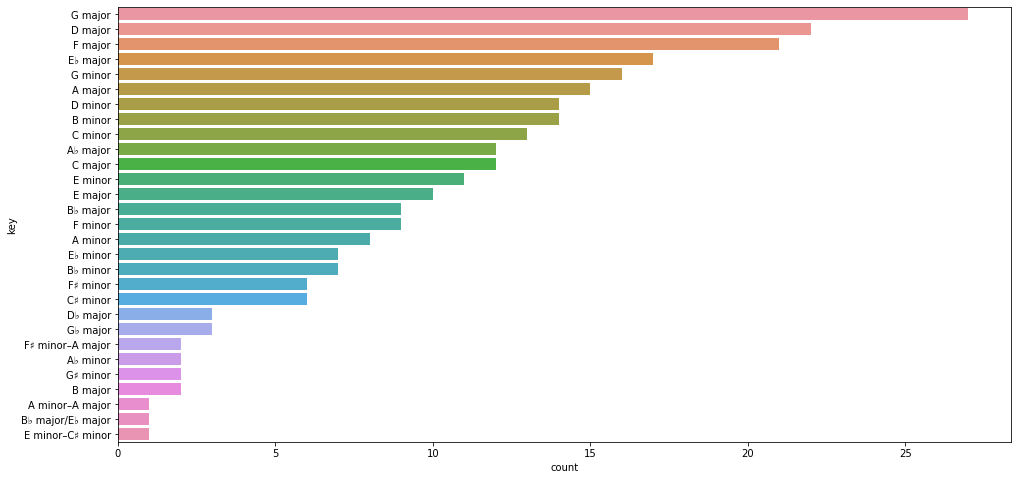

In [19]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['key'], data=df, order = df['key'].value_counts().index)

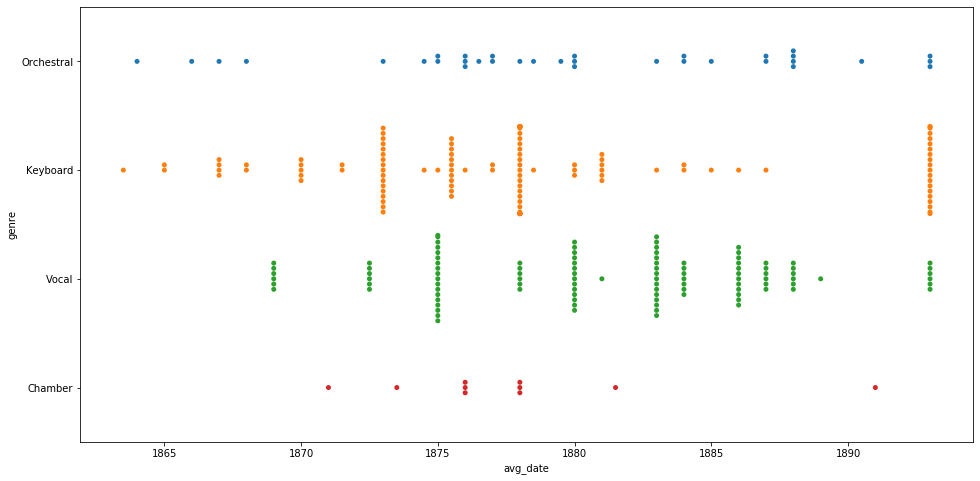

In [20]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['genre'])

In [21]:
# Last 1: F♯ major'
df.loc[df['key'] == 'G major']

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
14,55,Suite No.3,Сюита № 3,orch,G major,1884,Orchestral,also arr. for pf4h,major,1884,1884,1884.0
15,55,Suite No.3,Сюита № 3,pf4h,G major,1884,Keyboard,arr. of version for orch,major,1884,1884,1884.0
16,61,"Suite No.4 (""Mozartiana"")",Сюита № 4(«Моцартиана»),orch,G major,1887,Orchestral,arrs. of 4 pieces by Wolfgang Amadeus Mozart,major,1887,1887,1887.0
42,44,Piano Concerto No.2,Концерт для фортепиано с оркестром № 2,pf orch,G major,1879–80,Orchestral,rev. posthumously byAlexander Siloti; also arr...,major,1879,1880,1879.5
43,44,Piano Concerto No.2,Концерт для фортепиано с оркестром № 2,2pf,G major,1880,Keyboard,arr. of version for pf orch,major,1880,1880,1880.0
44,56,Concert Fantasia,Концертная фантазия,pf orch,G major,1884,Orchestral,also arr. for 2pf (1884).,major,1884,1884,1884.0
45,56,Concert Fantasia,Концертная фантазия,2pf,G major,1884,Keyboard,arr. of version for pf orch,major,1884,1884,1884.0
64,16/4,"O, Sing that Song","О, спой же ту песню",v pf,G major,1872–73,Vocal,also arr. for pf,major,1872,1873,1872.5
65,16/4,"O, Sing that Song","О, спой же ту песню",pf,G major,1873,Keyboard,arr. of version for v pf,major,1873,1873,1873.0
92,38/6,Pimpinella: Florentine Song,Пимпинелла: Флорентинская песня,v pf,G major,1878,Vocal,,major,1878,1878,1878.0


In [22]:
# Last 2: B♭ minor
df.loc[df["key"] == "D major"]

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
3,29,"Symphony No.3 (""Polish"")",Симфония № 3 («Польский»),orch,D major,1875,Orchestral,,major,1875,1875,1875.0
18,15,Festival Overture on the Danish National Anthem,Торжественная увертюра на Датский гимн,orch,D major,"1866, rev.1892",Orchestral,also arr. for pf4h,major,1866,1866,1866.0
19,15,Festival Overture on the Danish National Anthem,Торжественная увертюра на Датский гимн,pf4h,D major,1867,Keyboard,arr. of version for orch,major,1867,1867,1867.0
40,35,Violin Concerto,Концерт для скрипки с оркестром,vn orch,D major,1878,Orchestral,also arr. for vn pf (1878),major,1878,1878,1878.0
41,35,Violin Concerto,Концерт для скрипки с оркестром,vn pf,D major,1878,Keyboard,arr. of version for vn orch,major,1878,1878,1878.0
57,06/5,Why?,Отчего?,v pf,D major,1869,Vocal,,major,1869,1869,1869.0
90,38/4,"O, if Only You Could","О, если б ты могла",v pf,D major,1878,Vocal,,major,1878,1878,1878.0
120,54/12,Winter,Зима,v pf,D major,1883,Vocal,,major,1883,1883,1883.0
149,65/1,"Sérénade (""Où vas-tu, souffle d'aurore"")",Серенада («Ты куда летишь»),v pf,D major,1888,Vocal,,major,1888,1888,1888.0
161,11,String Quartet No.1,Струнный квартет № 1,2vn va vc,D major,1871,Chamber,2nd movt. arr. for cello and strings as TH 63,major,1871,1871,1871.0


In [23]:
# Last 3: F♯ minor
df.loc[df['key'] == 'F major']

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
77,27/3,Do Not Leave Me,Не отходи от меня,v pf,F major,1875,Vocal,,major,1875,1875,1875.0
91,38/5,The Love of a Dead Man,Любовь мертвеца,v pf,F major,1878,Vocal,,major,1878,1878,1878.0
97,46/5,Passion Spent,Минула страсть,sop ten pf,F major,1880,Vocal,,major,1880,1880,1880.0
102,47/3,Dusk Fell on the Earth,На землю сумрак пал,v pf,F major,1880,Vocal,,major,1880,1880,1880.0
104,47/5,"I Bless You, Forests","Благословляю вас, леса",v pf,F major,1880,Vocal,,major,1880,1880,1880.0
117,540/8,"Spring (""The Snow is Already Melting"")",Весна (Уж тает снег),v pf,F major,1883,Vocal,,major,1883,1883,1883.0
118,54/10,Lullaby in a Storm,Колыбельная песнь в бурю,v pf,F major,1883,Vocal,,major,1883,1883,1883.0
119,54/11,The Little Flower,Цветок,v pf,F major,1883,Vocal,,major,1883,1883,1883.0
128,57/4,Sleep!,Усни!,v pf,F major,1884,Vocal,,major,1884,1884,1884.0
135,60/0/5,Simple Words,Простые слова,v pf,F major,1886,Vocal,,major,1886,1886,1886.0


## Genre

In [24]:
df['genre'].unique()

array(['Orchestral', 'Keyboard', 'Vocal', 'Chamber'], dtype=object)

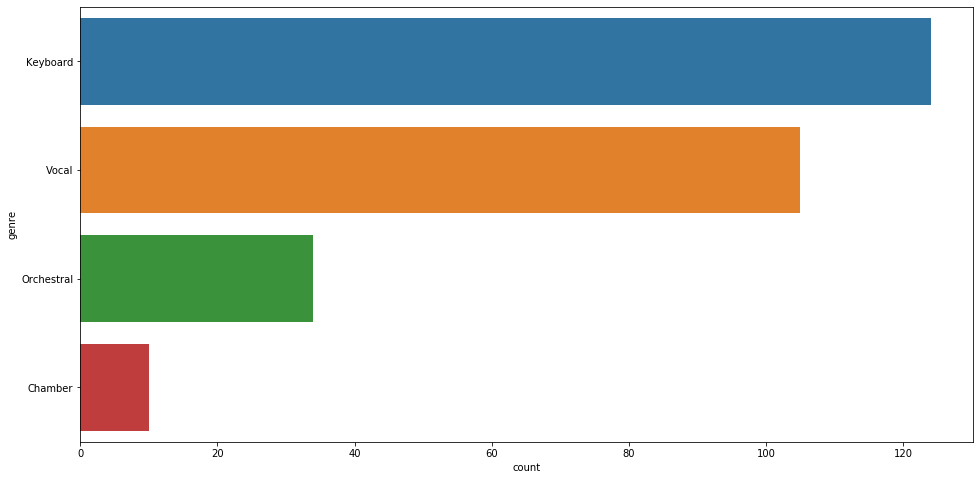

In [25]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['genre'], data=df, order=df['genre'].value_counts().index)

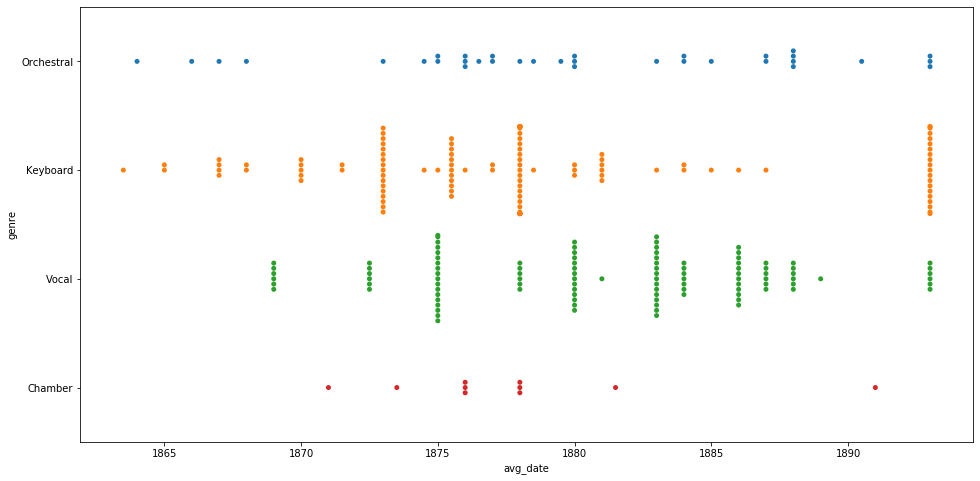

In [26]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['genre'])

In [27]:
df.loc[df['genre'] == 'Orchestral']

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
0,13,"Symphony No.1 (""Winter Daydreams"")",Симфония № 1 («Зимние грезы»),orch,G minor,"1866–68, rev. 1874",Orchestral,,minor,1866,1868,1867.0
1,17,"Symphony No.2 (""Little Russian"")",Симфония № 2 («Малороссийская»),orch,C minor,"1872, rev. 1879–80",Orchestral,also arr. for pf4h,minor,1872,1880,1876.0
3,29,"Symphony No.3 (""Polish"")",Симфония № 3 («Польский»),orch,D major,1875,Orchestral,,major,1875,1875,1875.0
4,36,Symphony No.4,Симфония № 4,orch,F minor,1877,Orchestral,,minor,1877,1877,1877.0
5,58,Manfred,Манфред,orch,B minor,1885,Orchestral,symphony in 4 scenes based on the dramatic poe...,minor,1885,1885,1885.0
7,64,Symphony No.5,Симфония № 5,orch,E minor,1888,Orchestral,,minor,1888,1888,1888.0
8,74,"Symphony No.6 (""Pathétique"")",Симфония № 6 («Патетическая»),orch,B minor,1893,Orchestral,also arr. for pf4h,minor,1893,1893,1893.0
10,43,Suite No.1,Сюита № 1,orch,D minor,1878–79,Orchestral,also arr. for pf4h,minor,1878,1879,1878.5
12,53,"Suite No.2 (""Suite caractéristique"")",Сюита № 2,orch,C major,1883,Orchestral,also arr. for pf4h,major,1883,1883,1883.0
14,55,Suite No.3,Сюита № 3,orch,G major,1884,Orchestral,also arr. for pf4h,major,1884,1884,1884.0


## Masterpiece: Concerto

In [28]:
df.loc[df['title'].str.contains('Concerto', case = False)]

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
32,23,Piano Concerto No.1,Концерт для фортепиано с оркестром № 1,pf orch,B♭ minor,"1874–75, rev. 1879, 1890",Orchestral,also arr. for 2pf,minor,1874,1875,1874.5
33,23,Piano Concerto No.1,Концерт для фортепиано с оркестром № 1,2pf,B♭ minor,"1874–75, rev. 1879, 1890",Keyboard,arr. of version for pf orch,minor,1874,1875,1874.5
40,35,Violin Concerto,Концерт для скрипки с оркестром,vn orch,D major,1878,Orchestral,also arr. for vn pf (1878),major,1878,1878,1878.0
41,35,Violin Concerto,Концерт для скрипки с оркестром,vn pf,D major,1878,Keyboard,arr. of version for vn orch,major,1878,1878,1878.0
42,44,Piano Concerto No.2,Концерт для фортепиано с оркестром № 2,pf orch,G major,1879–80,Orchestral,rev. posthumously byAlexander Siloti; also arr...,major,1879,1880,1879.5
43,44,Piano Concerto No.2,Концерт для фортепиано с оркестром № 2,2pf,G major,1880,Keyboard,arr. of version for pf orch,major,1880,1880,1880.0
50,75,Piano Concerto No.3,Концерт для фортепиано с оркестром № 3,pf orch,E♭ major,1893,Orchestral,based on sketches for TH 238; only 1st movt. o...,major,1893,1893,1893.0
51,75,Piano Concerto No.3,Концерт для фортепиано с оркестром № 3,2pf,E♭ major,1893,Keyboard,"arr. of version for pf orch, 1st movt.",major,1893,1893,1893.0


## Masterpiece: String Quartet

In [29]:
df.loc[df['title'].str.contains('String Quartet')]

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
161,11,String Quartet No.1,Струнный квартет № 1,2vn va vc,D major,1871,Chamber,2nd movt. arr. for cello and strings as TH 63,major,1871,1871,1871.0
162,22,String Quartet No.2,Струнный квартет № 2,2vn va vc,F major,1873–74,Chamber,,major,1873,1874,1873.5
163,30,String Quartet No.3,Струнный квартет № 3,2vn va vc,E♭ minor,1876,Chamber,3rd movt. arr. for violin and piano as TH 114,minor,1876,1876,1876.0


## Masterpiece: Symphony

In [30]:
df.loc[df['title'].str.contains('Symphony')]

,opus,title,russian title,instruments,key,date,genre,notes,mode,min_date,max_date,avg_date
0,13,"Symphony No.1 (""Winter Daydreams"")",Симфония № 1 («Зимние грезы»),orch,G minor,"1866–68, rev. 1874",Orchestral,,minor,1866,1868,1867.0
1,17,"Symphony No.2 (""Little Russian"")",Симфония № 2 («Малороссийская»),orch,C minor,"1872, rev. 1879–80",Orchestral,also arr. for pf4h,minor,1872,1880,1876.0
2,17,"Symphony No.2 (""Little Russian"")",Симфония № 2 («Малороссийская»),pf4h,C minor,"1873, rev. 1880",Keyboard,arr. of version for orch,minor,1873,1873,1873.0
3,29,"Symphony No.3 (""Polish"")",Симфония № 3 («Польский»),orch,D major,1875,Orchestral,,major,1875,1875,1875.0
4,36,Symphony No.4,Симфония № 4,orch,F minor,1877,Orchestral,,minor,1877,1877,1877.0
7,64,Symphony No.5,Симфония № 5,orch,E minor,1888,Orchestral,,minor,1888,1888,1888.0
8,74,"Symphony No.6 (""Pathétique"")",Симфония № 6 («Патетическая»),orch,B minor,1893,Orchestral,also arr. for pf4h,minor,1893,1893,1893.0
9,74,"Symphony No.6 (""Pathétique"")",Симфония № 6 («Патетическая»),pf4h,B minor,1893,Keyboard,arr. of version for orch,minor,1893,1893,1893.0
